In [1]:
import sys
sys.path.append('../')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from pathlib import Path

import matplotlib.pyplot as plt

from util.true_gaussian_process import *

from ofm_OT_likelihood import *
from models.fno import FNO

import statsmodels.api as sm
from scipy.stats import binned_statistic
import statsmodels.api as sm
from scipy.stats import binned_statistic

import torchvision
from torchvision import transforms
from torch.utils.data import Subset
import scipy
import os

In [2]:
n_x = 64
dims = [n_x, n_x]

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
spath = Path('your_path/SDF_MNIST')

spath.mkdir(parents=True, exist_ok=True)
saved_model = True # save model

# FNO hyperparameters
modes = 32
width = 128
mlp_width = 128

# GP hyperparameters
kernel_length=0.01
kernel_variance=1
nu = 0.5 # default

## training parameters
epochs = 500
sigma_min=1e-4
N = 1
batch_size = 256

In [3]:
def get_mgrid(sidelen):
    # Generate 2D pixel coordinates from an image of sidelen x sidelen
    pixel_coords = np.stack(np.mgrid[:sidelen,:sidelen], axis=-1)[None,...].astype(np.float32)
    pixel_coords /= sidelen    
    pixel_coords -= 0.5
    pixel_coords = torch.Tensor(pixel_coords).view(-1, 2)
    return pixel_coords

class SignedDistanceTransform:
    def __call__(self, img_tensor):
        # Threshold.
        img_tensor[img_tensor<0.5] = 0.
        img_tensor[img_tensor>=0.5] = 1.

        # Compute signed distances with distance transform
        img_tensor = img_tensor.numpy()

        neg_distances = scipy.ndimage.distance_transform_edt(img_tensor)
        sd_img = img_tensor - 1.
        sd_img = sd_img.astype(np.uint8)
        signed_distances = scipy.ndimage.distance_transform_edt(sd_img) - neg_distances
        signed_distances /= float(img_tensor.shape[1])
        signed_distances = torch.Tensor(signed_distances)

        return signed_distances, torch.Tensor(img_tensor)
    
class MNISTSDFDataset(torch.utils.data.Dataset):
    def __init__(self, split, size=(256,256), subset=True, n_samples=6000): #60000 samples in total
        self.transform = transforms.Compose([
            transforms.Resize(size),
            transforms.ToTensor(),
            SignedDistanceTransform(),
        ])
        img_dataset = torchvision.datasets.MNIST('../data/MNIST', train=True if split == 'train' else False,
                                                download=False)
        if subset == True:
            subset_indices = np.random.choice(len(img_dataset), n_samples, replace=False)
            self.img_dataset = Subset(img_dataset, subset_indices)
            self.n_samples = n_samples
        else:
            self.img_dataset = img_dataset
            self.n_samples = len(img_dataset)
        
        self.meshgrid = get_mgrid(size[0])
        self.im_size = size

    def __len__(self):
        return len(self.img_dataset)

    def __getitem__(self, item):
        img, digit_class = self.img_dataset[item]

        signed_distance_img, binary_image = self.transform(img)
        #print('signed_distance_img shape:{}'.format(signed_distance_img.shape))
        #signed_distance_values = signed_distance_img.reshape((-1, 1))
        
        return signed_distance_img
    
    def get_N_samples(self, N=10):
        sample_ids = np.random.choice(self.n_samples, N, replace=False)
        samples = []
        for sample_id in sample_ids:
            
            img, digit_class = self.img_dataset[sample_id]
            signed_distance_img, binary_image = self.transform(img)
            samples.append(signed_distance_img)
            
        return torch.vstack(samples)
        
    def get_dict(self, item):
        img, digit_class = self.img_dataset[item]

        signed_distance_img, binary_image = self.transform(img)
        
        coord_values = self.meshgrid.reshape(-1, 2)
        signed_distance_values = signed_distance_img.reshape((-1, 1))
        
        indices = torch.randperm(coord_values.shape[0])
        support_indices = indices[:indices.shape[0]//2]
        query_indices = indices[indices.shape[0]//2:]

        meta_dict = {'context': {'x':coord_values[support_indices], 'y':signed_distance_values[support_indices]}, 
                     'query': {'x':coord_values[query_indices], 'y':signed_distance_values[query_indices]}, 
                     'all': {'x':coord_values, 'y':signed_distance_values}}
        
        return meta_dict

In [4]:
train_dataset = MNISTSDFDataset('train', size=(64, 64), subset=True, n_samples=20000)


#train_dataset = MNISTSDFDataset('train', size=(64, 64))
val_dataset = MNISTSDFDataset('val', size=(64, 64))

loader_tr = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)



In [5]:
def compute_acovf(z):
    # z shape : [n, ndim, ndim]
    res = z.shape[-1]
    z_hat = torch.fft.rfft2(z)
    acf = torch.fft.irfft2(torch.conj(z_hat) * z_hat)
    acf = torch.fft.fftshift(acf).mean(dim=0) / z[0].numel() # ndim*ndim
    acf_r = acf.view(-1).cpu().detach().numpy()
    lags_x, lags_y = torch.meshgrid(torch.arange(res) - res//2, torch.arange(res) - res//2)
    lags_r = torch.sqrt(lags_x**2 + lags_y**2).view(-1).cpu().detach().numpy()

    idx = np.argsort(lags_r)
    lags_r = lags_r[idx]
    acf_r = acf_r[idx]

    bin_means, bin_edges, binnumber = binned_statistic(lags_r, acf_r, 'mean', bins=np.linspace(0.0, res, 50))
    return bin_edges[:-1], bin_means

In [6]:
for i in range(N):
    model = FNO(modes, vis_channels=1, hidden_channels=width, proj_channels=mlp_width, x_dim=2, t_scaling=1).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    #scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=25)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.8)
    fmot = OFMModel(model, kernel_length=kernel_length, kernel_variance=kernel_variance, nu=nu, sigma_min=sigma_min, device=device, dims=dims)
    fmot.train(loader_tr, optimizer, epochs=epochs, scheduler=scheduler, eval_int=int(0), save_int=int(500), generate=False, save_path=spath,saved_model=saved_model)

tr @ epoch 1/500 | Loss 0.232071 | 89.53 (s)
tr @ epoch 2/500 | Loss 0.034707 | 84.95 (s)
tr @ epoch 3/500 | Loss 0.024490 | 61.10 (s)
tr @ epoch 4/500 | Loss 0.020679 | 59.96 (s)
tr @ epoch 5/500 | Loss 0.019214 | 59.45 (s)
tr @ epoch 6/500 | Loss 0.018334 | 59.70 (s)
tr @ epoch 7/500 | Loss 0.017857 | 59.27 (s)
tr @ epoch 8/500 | Loss 0.015890 | 59.87 (s)
tr @ epoch 9/500 | Loss 0.015195 | 59.51 (s)
tr @ epoch 10/500 | Loss 0.014622 | 59.82 (s)
tr @ epoch 11/500 | Loss 0.014100 | 59.37 (s)
tr @ epoch 12/500 | Loss 0.013824 | 59.91 (s)
tr @ epoch 13/500 | Loss 0.013629 | 59.57 (s)
tr @ epoch 14/500 | Loss 0.012818 | 59.46 (s)
tr @ epoch 15/500 | Loss 0.013007 | 60.01 (s)
tr @ epoch 16/500 | Loss 0.013898 | 59.62 (s)
tr @ epoch 17/500 | Loss 0.012265 | 59.99 (s)
tr @ epoch 18/500 | Loss 0.012454 | 60.05 (s)
tr @ epoch 19/500 | Loss 0.012641 | 65.81 (s)
tr @ epoch 20/500 | Loss 0.012216 | 60.16 (s)
tr @ epoch 21/500 | Loss 0.011973 | 60.06 (s)
tr @ epoch 22/500 | Loss 0.011486 | 60.39 (

tr @ epoch 178/500 | Loss 0.007350 | 59.98 (s)
tr @ epoch 179/500 | Loss 0.007515 | 59.71 (s)
tr @ epoch 180/500 | Loss 0.007699 | 59.85 (s)
tr @ epoch 181/500 | Loss 0.007271 | 59.91 (s)
tr @ epoch 182/500 | Loss 0.007456 | 59.70 (s)
tr @ epoch 183/500 | Loss 0.007380 | 60.02 (s)
tr @ epoch 184/500 | Loss 0.007666 | 60.00 (s)
tr @ epoch 185/500 | Loss 0.007790 | 60.34 (s)
tr @ epoch 186/500 | Loss 0.007687 | 60.11 (s)
tr @ epoch 187/500 | Loss 0.006938 | 60.30 (s)
tr @ epoch 188/500 | Loss 0.007399 | 60.34 (s)
tr @ epoch 189/500 | Loss 0.007483 | 60.19 (s)
tr @ epoch 190/500 | Loss 0.007064 | 60.54 (s)
tr @ epoch 191/500 | Loss 0.007193 | 60.12 (s)
tr @ epoch 192/500 | Loss 0.007866 | 60.24 (s)
tr @ epoch 193/500 | Loss 0.007432 | 60.42 (s)
tr @ epoch 194/500 | Loss 0.006989 | 59.83 (s)
tr @ epoch 195/500 | Loss 0.007071 | 59.94 (s)
tr @ epoch 196/500 | Loss 0.006882 | 59.68 (s)
tr @ epoch 197/500 | Loss 0.007290 | 59.79 (s)
tr @ epoch 198/500 | Loss 0.007565 | 59.65 (s)
tr @ epoch 19

tr @ epoch 353/500 | Loss 0.006359 | 60.12 (s)
tr @ epoch 354/500 | Loss 0.006842 | 59.79 (s)
tr @ epoch 355/500 | Loss 0.006446 | 59.45 (s)
tr @ epoch 356/500 | Loss 0.006515 | 60.39 (s)
tr @ epoch 357/500 | Loss 0.006155 | 60.23 (s)
tr @ epoch 358/500 | Loss 0.006524 | 60.31 (s)
tr @ epoch 359/500 | Loss 0.006216 | 61.62 (s)
tr @ epoch 360/500 | Loss 0.006455 | 61.47 (s)
tr @ epoch 361/500 | Loss 0.006540 | 60.52 (s)
tr @ epoch 362/500 | Loss 0.006289 | 59.70 (s)
tr @ epoch 363/500 | Loss 0.006757 | 60.47 (s)
tr @ epoch 364/500 | Loss 0.006533 | 60.18 (s)
tr @ epoch 365/500 | Loss 0.006427 | 60.47 (s)
tr @ epoch 366/500 | Loss 0.006928 | 64.74 (s)
tr @ epoch 367/500 | Loss 0.006864 | 62.98 (s)
tr @ epoch 368/500 | Loss 0.006682 | 60.74 (s)
tr @ epoch 369/500 | Loss 0.006246 | 60.02 (s)
tr @ epoch 370/500 | Loss 0.006499 | 61.46 (s)
tr @ epoch 371/500 | Loss 0.006294 | 61.21 (s)
tr @ epoch 372/500 | Loss 0.006617 | 59.83 (s)
tr @ epoch 373/500 | Loss 0.006209 | 59.80 (s)
tr @ epoch 37

## load trained model

In [6]:
## load trained model
model = FNO(modes, vis_channels=1, hidden_channels=width, proj_channels=mlp_width, x_dim=2, t_scaling=1).to(device)

for param in model.parameters():
    param.requires_grad = False
# paper :model_path = path "paper_saved_models/{}/1D_codomain_649_set1.pt".format(folder)
model_path = os.path.join(spath, 'epoch_500.pt')
checkpoint = torch.load(model_path, map_location='cpu', weights_only=True)
model.load_state_dict(checkpoint)

fmot = OFMModel(model, kernel_length=kernel_length, kernel_variance=kernel_variance, nu=nu, sigma_min=sigma_min, device=device, dims=dims)

## statistical features

In [7]:

paper_folder = 'MNIST_SDF'

if not os.path.exists(f"../Generation_results/{paper_folder}"):
    os.makedirs(f"../Generation_results/{paper_folder}")

In [9]:
x_train = val_dataset.get_N_samples(N=6000)
x_train = torch.Tensor(x_train)
#x_train = torch.exp(x_train*x_std + x_mean)
x_hist_true, bin_edges = x_train.histogram(range=[-4,4], density=True)
x_pos = np.linspace(0, 1, n_x)

/home/yshi5/miniconda3/envs/torchcfm/lib/python3.10/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


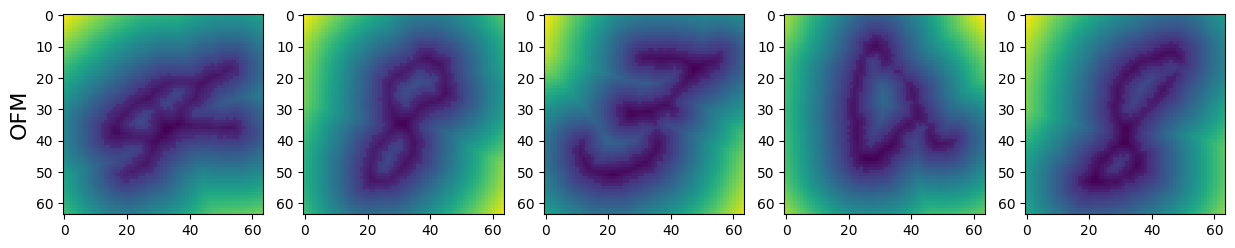

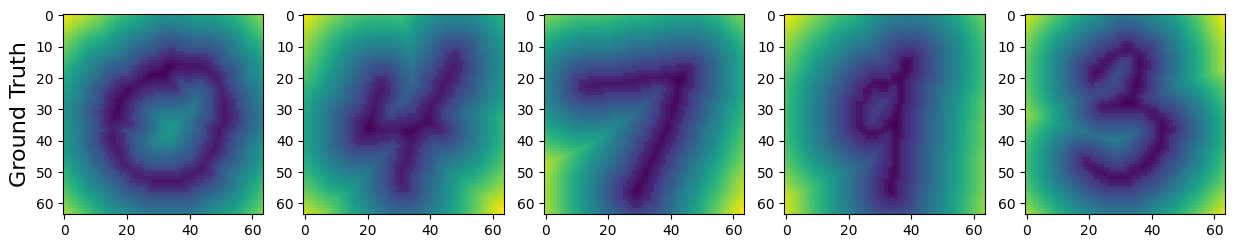

In [10]:
with torch.no_grad():

    X_hat = fmot.sample([n_x, n_x], n_samples=10, n_eval=10).cpu()
    #X_hat = torch.exp(X_hat*x_std + x_mean).squeeze()
    
    X_ground_truth = x_train[:5].squeeze()
    # plot
    
    X_alt = []
    for i in range(5):
        X_temp = fmot.sample([n_x, n_x], n_samples=200, n_eval=10).cpu().squeeze()
        X_alt.append(X_temp)
        
    X_alt = torch.vstack(X_alt)
    #X_alt = torch.exp(X_alt * x_std + x_mean)
    
    bin_center, x_acovf = compute_acovf(X_alt.squeeze())
    #x_train = torch.exp(x_train*x_std + x_mean)
    _, x_acovf_true = compute_acovf(x_train.squeeze())
    x_hist, bin_edges_alt = X_alt.histogram(range=[-4,4], density=True)
    x_hist_true, bin_edges = x_train.histogram(range=[-4, 4], density=True)
    
    fig, ax = plt.subplots(1,5, figsize=(15,3))
    for i in range(5):
        x = X_hat[-i,:,:].squeeze()

        ax[i].imshow(x)#, vmin=-2, vmax=2)
        if i == 0:
            ax[i].set_ylabel('OFM', fontsize=16)
        
    #cb = fig.colorbar(ax[4].imshow(), , orientation='vertical')
    #bar = ax[4].imshow(x)#, vmin=-2, vmax=2)
    #fig.colorbar(bar, ax=ax)
    #plt.show()
    plt.savefig(f"../Generation_results/{paper_folder}/SDF_samples.pdf")
    
    
    fig, ax = plt.subplots(1,5, figsize=(15,3))    
    for i in range(5):
        x_ground_truth = X_ground_truth[i,:,:].squeeze()
        ax[i].imshow(x_ground_truth)#, vmin=-2, vmax=2)
        if i == 0:
            ax[i].set_ylabel('Ground Truth', fontsize=16)
    plt.savefig(f"../Generation_results/{paper_folder}/SDF_gt_samples.pdf")


In [14]:
n_x_sup = 128
train_dataset = MNISTSDFDataset('val', size=(128, 128), subset=True, n_samples=6000)

x_train = train_dataset.get_N_samples(N=6000)
x_train = torch.Tensor(x_train)

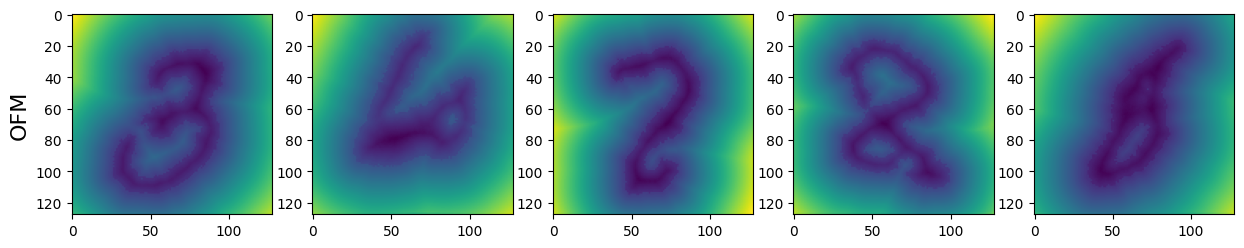

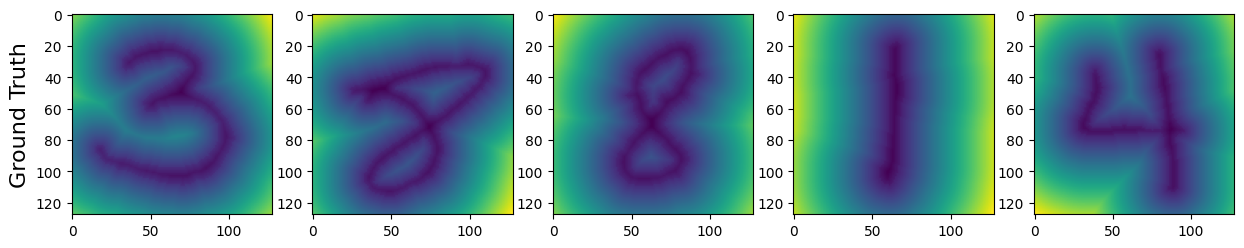

In [15]:
with torch.no_grad():

    X_hat = fmot.sample([n_x_sup, n_x_sup], n_samples=10, n_eval=10).cpu()
    #X_hat = torch.exp(X_hat*x_std + x_mean).squeeze()
    
    X_ground_truth = x_train[:5].squeeze()
    # plot
    
    fig, ax = plt.subplots(1,5, figsize=(15,3))
    for i in range(5):
        x = X_hat[-i,:,:].squeeze()

        ax[i].imshow(x)#, vmin=-2, vmax=2)
        if i == 0:
            ax[i].set_ylabel('OFM', fontsize=16)
        
    #cb = fig.colorbar(ax[4].imshow(), , orientation='vertical')
    #bar = ax[4].imshow(x)#, vmin=-2, vmax=2)
    #fig.colorbar(bar, ax=ax)
    #plt.show()
    plt.savefig(f"../Generation_results/{paper_folder}/SDF_samples_sup_128.pdf")
    
    
    fig, ax = plt.subplots(1,5, figsize=(15,3))    
    for i in range(5):
        x_ground_truth = X_ground_truth[i,:,:].squeeze()
        ax[i].imshow(x_ground_truth)#, vmin=-2, vmax=2)
        if i == 0:
            ax[i].set_ylabel('Ground Truth', fontsize=16)
    plt.savefig(f"../Generation_results/{paper_folder}/SDF_gt_samples_sup_128.pdf")